In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

In [3]:
# 1. American Option Pricing using Binomial Tree Model
def american_option_price(S, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    ST = np.array([S * u**j * d**(N-j) for j in range(N+1)])
    
    # Initialize option values at maturity
    if option_type == 'call':
        C = np.maximum(ST - K, 0)
    else:  # put
        C = np.maximum(K - ST, 0)

    # Iterate backwards
    for i in range(N-1, -1, -1):
        ST = ST[:-1] / u  # Asset prices one step earlier
        C_hold = np.exp(-r * dt) * (p * C[1:] + (1-p) * C[:-1])
        if option_type == 'call':
            C = np.maximum(C_hold, ST - K)
        else:  # put
            C = np.maximum(C_hold, K - ST)

    return C[0]



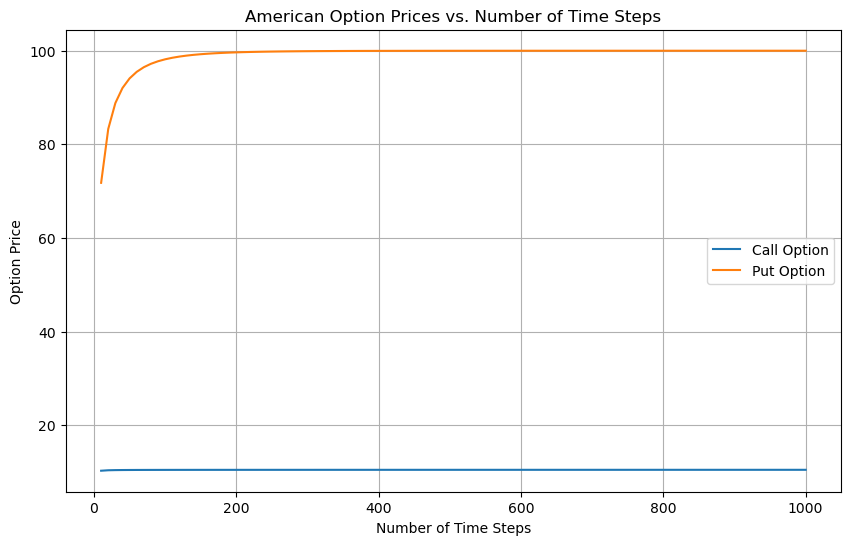

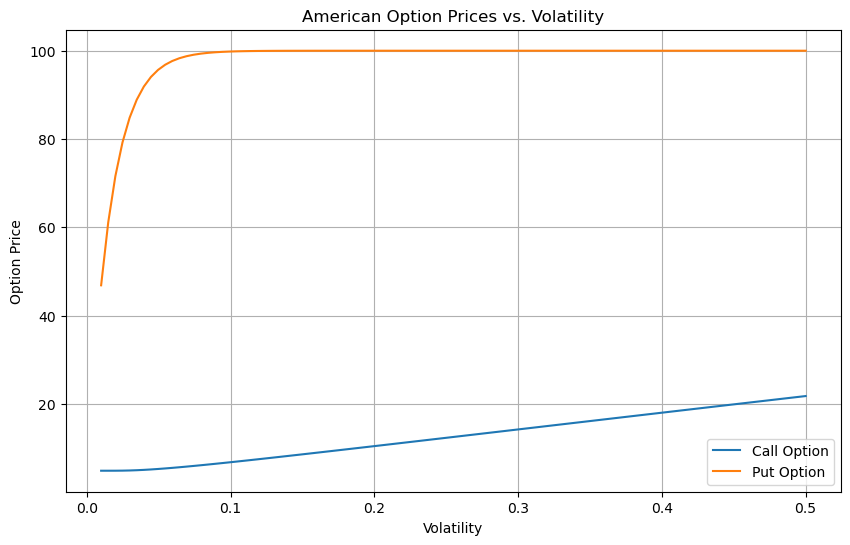

In [4]:
# 2. Analysis of American Option Prices
S0 = 100  # Current stock price
K = 100   # Strike price
T = 1     # Time to expiration (in years)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Analyze price with respect to number of time steps
N_values = range(10, 1001, 10)
call_prices = [american_option_price(S0, K, T, r, sigma, N) for N in N_values]
put_prices = [american_option_price(S0, K, T, r, sigma, N, 'put') for N in N_values]

plt.figure(figsize=(10, 6))
plt.plot(N_values, call_prices, label='Call Option')
plt.plot(N_values, put_prices, label='Put Option')
plt.xlabel('Number of Time Steps')
plt.ylabel('Option Price')
plt.title('American Option Prices vs. Number of Time Steps')
plt.legend()
plt.grid(True)
plt.show()

# Analyze price with respect to volatility
sigma_values = np.linspace(0.01, 0.5, 100)
call_prices_sigma = [american_option_price(S0, K, T, r, sigma, 1000) for sigma in sigma_values]
put_prices_sigma = [american_option_price(S0, K, T, r, sigma, 1000, 'put') for sigma in sigma_values]

plt.figure(figsize=(10, 6))
plt.plot(sigma_values, call_prices_sigma, label='Call Option')
plt.plot(sigma_values, put_prices_sigma, label='Put Option')
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.title('American Option Prices vs. Volatility')
plt.legend()
plt.grid(True)
plt.show()



The first two graphs show how American option prices change with respect to the number of time steps and volatility.
a) American Option Prices vs. Number of Time Steps:

Both call and put option prices converge as the number of time steps increases.
This convergence demonstrates that the binomial tree model becomes more accurate with finer time discretization.
The put option price is higher than the call option price, which is typical for American options when other parameters are equal, due to the early exercise feature.

b) American Option Prices vs. Volatility:

- Both call and put option prices increase with higher volatility.
- This relationship is expected because higher volatility implies a greater chance of the option becoming more valuable before expiration.
- The rate of increase is more pronounced for call options at higher volatilities, suggesting they benefit more from increased market uncertainty.

Implications:

- The ability to exercise American options early provides additional value, especially for put options.
- Accurate pricing requires a sufficient number of time steps in the binomial model.
- Option writers need to be particularly cautious in high-volatility environments.

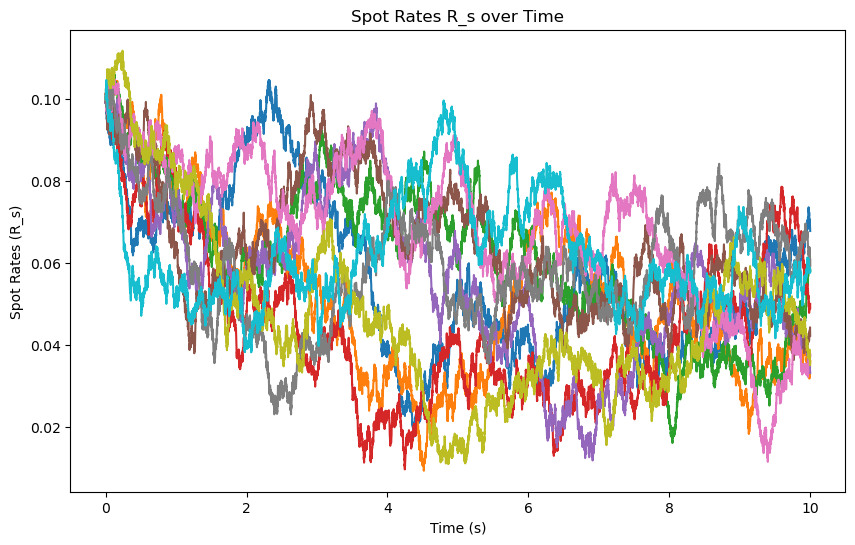

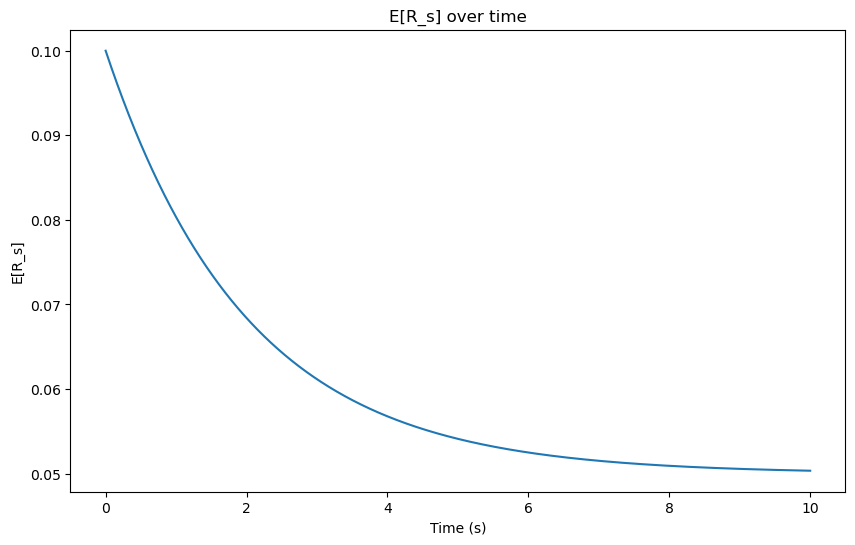

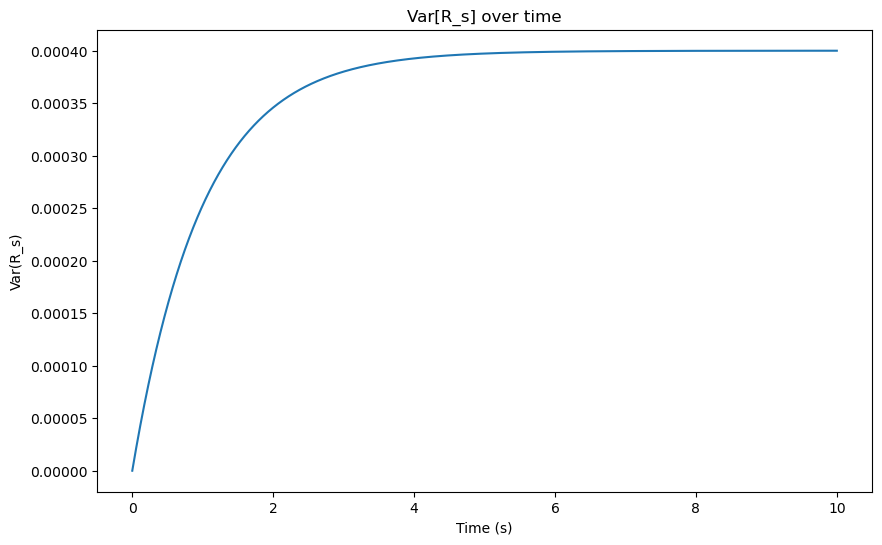

In [5]:
# 3. Ornstein-Uhlenbeck Process
def simulate_ou_process(n, N, Delta, theta, sigma, R0, mu):
    times = np.arange(n+1) * Delta
    X = np.zeros((N, n+1))
    for i in range(1, n+1):
        x = X[:, i-1]
        m = x * np.exp(-theta * Delta)
        v = (sigma**2 / (2*theta)) * (1 - np.exp(-2*theta * Delta))
        X[:, i] = np.random.normal(m, np.sqrt(v), N)
    
    Rt = np.exp(-theta * times) * R0 + (1 - np.exp(-theta * times)) * mu + X
    return times, Rt

# Simulate OU process
n = 10000
N = 10
Delta = 10 / n
theta = 0.5
sigma = 0.02
R0 = 0.1
mu = 0.05

times, Rt = simulate_ou_process(n, N, Delta, theta, sigma, R0, mu)

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(times, Rt[i, :])
plt.xlabel('Time (s)')
plt.ylabel('Spot Rates (R_s)')
plt.title('Spot Rates R_s over Time')
plt.show()

# Plot expectation and variance
expRt = np.exp(-theta * times) * R0 + (1 - np.exp(-theta * times)) * mu
varRt = (sigma**2 / (2*theta)) * (1 - np.exp(-2*theta * times))

plt.figure(figsize=(10, 6))
plt.plot(times, expRt)
plt.xlabel('Time (s)')
plt.ylabel('E[R_s]')
plt.title('E[R_s] over time')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(times, varRt)
plt.xlabel('Time (s)')
plt.ylabel('Var(R_s)')
plt.title('Var[R_s] over time')
plt.show()



Spot Rates R_s over Time:

- The graph shows multiple simulations of the spot rate process.
- Rates fluctuate around a mean level, demonstrating the mean-reverting property of the O-U process.
- This behavior mimics real-world interest rates that tend to revert to a long-term average.

b) E[R_s] over time:

- The expected value of the spot rate converges to the long-term mean (mu).
- This illustrates the mean-reverting nature of the process in the long run.

c) Var[R_s] over time:

- The variance increases over time but approaches a constant value.
- This suggests that while short-term predictions may be more accurate, long-term rate forecasts have a stable level of uncertainty.

Implications:

- The O-U process provides a reasonable model for interest rates, capturing mean reversion.
- It allows for short-term fluctuations while maintaining long-term stability.
- This model can be useful for risk management and pricing of interest rate-dependent securities.

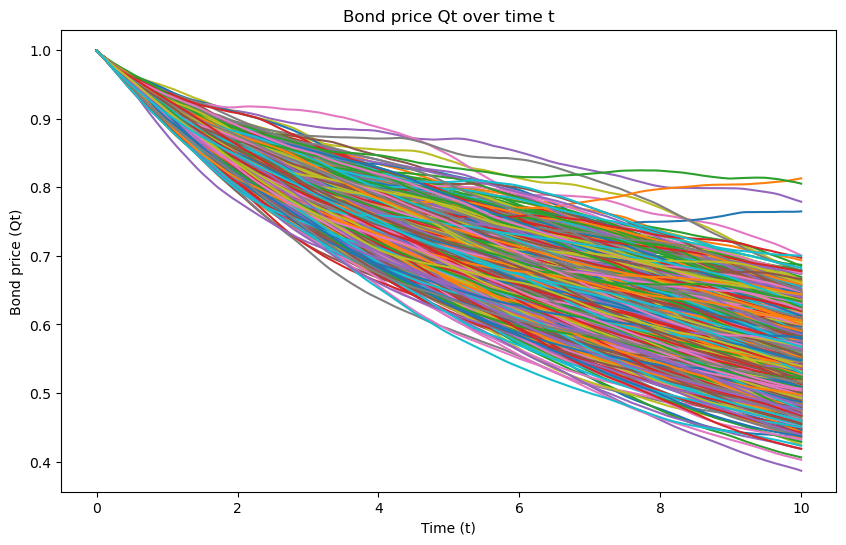

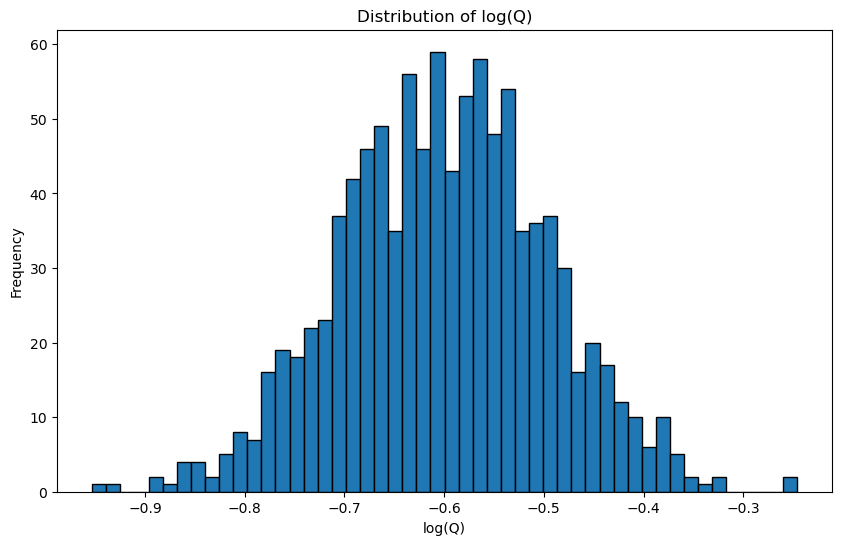

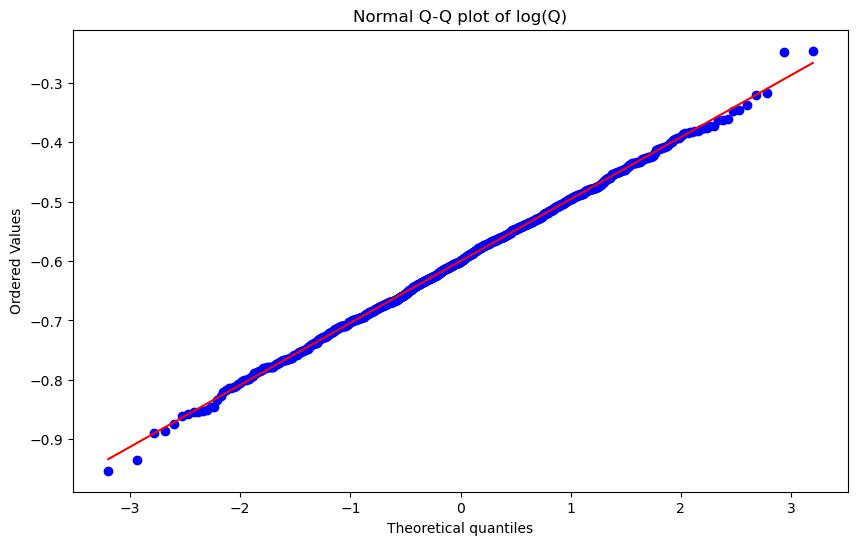

Mean of log(Q): -0.6000891301263563
Variance of log(Q): 0.010807831141708977


In [10]:
# 4. Vasicek Model
def simulate_vasicek(n, N, Delta, theta, sigma, R0, mu):
    times, Rt = simulate_ou_process(n, N, Delta, theta, sigma, R0, mu)
    Q = np.exp(-Delta * np.cumsum(Rt, axis=1))
    return times, Q

times, Q = simulate_vasicek(n, N, Delta, theta, sigma, R0, mu)

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(times, Q[i, :])
plt.xlabel('Time (t)')
plt.ylabel('Bond price (Qt)')
plt.title('Bond price Qt over time t')
plt.show()

# Distribution of Qt
n = 1000
N = 1000
Delta = 10 / n
times, Q = simulate_vasicek(n, N, Delta, theta, sigma, R0, mu)

logQ = np.log(Q[:, -1])

plt.figure(figsize=(10, 6))
plt.hist(logQ, bins=50, edgecolor='black')
plt.xlabel('log(Q)')
plt.ylabel('Frequency')
plt.title('Distribution of log(Q)')
plt.show()

plt.figure(figsize=(10, 6))
stats.probplot(logQ, dist="norm", plot=plt)
plt.title('Normal Q-Q plot of log(Q)')
plt.show()
plt.close()

print(f"Mean of log(Q): {np.mean(logQ)}")
print(f"Variance of log(Q): {np.var(logQ)}")

In [ ]:
Vasicek Model:

a) Bond price Qt over time t:

- The graph shows multiple simulations of bond prices over time.
- Prices generally decrease over time, which is expected as the bond approaches maturity.
- There's significant variation in paths, reflecting the stochastic nature of interest rates.

b) Distribution of log(Q):

- The histogram of log(Q) appears approximately normal.
- This is confirmed by the Q-Q plot, which shows points close to the diagonal line.
- The mean of log(Q) is negative (-0.6001), indicating that on average, the bond price at maturity is less than 1 (as e^-0.6001 ≈ 0.5488).
- The variance of log(Q) is relatively small (0.0108), suggesting that while there is variability, it's not extreme.

Implications:

- The Vasicek model provides a way to simulate realistic bond price trajectories.
- The log-normal distribution of bond prices aligns with financial theory and allows for analytical tractability in some applications.
- The model captures both the time decay of bond prices and the uncertainty due to stochastic interest rates.

1. The American option pricing model demonstrates the additional complexity and value of early exercise rights compared to European options.
2. The Ornstein-Uhlenbeck process and Vasicek model provide a framework for modeling interest rates and bond prices that capture key real-world characteristics like mean reversion and stochastic volatility.
3. These models are valuable tools for risk management, derivative pricing, and portfolio optimization in fixed income markets.
4. However, it's important to note that these models make simplifying assumptions. In practice, factors like changing volatility, jumps in asset prices, or more complex interest rate dynamics might need to be considered for more accurate real-world modeling.